#  Make draws form arb dist

In [2]:
import itertools

import matplotlib.pyplot as plt
import matplotlib as mpl
from pymc3 import Model, Normal, Slice
from pymc3 import sample
from pymc3 import traceplot
from pymc3.distributions import Interpolated
from theano import as_op
import theano.tensor as tt
import numpy as np
from scipy import stats
import tqdm

%matplotlib inline

%load_ext version_information

%version_information pymc3, scipy



Software versions
Python 3.6.2 64bit [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
IPython 6.1.0
OS Darwin 15.6.0 x86_64 i386 64bit
pymc3 3.1
scipy 0.19.1
Mon Sep 18 13:09:59 2017 MDT

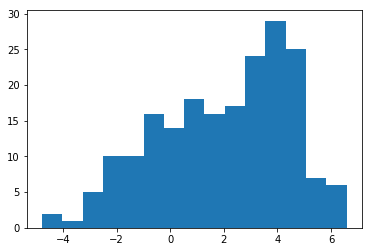

In [3]:
np.random.seed(8675309)
x = stats.norm.rvs(loc=0, scale=2, size=100)
x = np.append(x, stats.norm.rvs(loc=4, scale=1, size=100))
plt.hist(x, 15, normed=False);


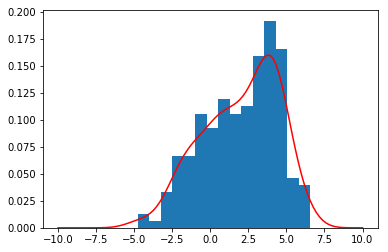

In [4]:
# fit a gaussian kde
kde = stats.gaussian_kde(x)

xx = np.linspace(-10,10, 100)
plt.hist(x, 15, normed=True);
plt.plot(xx, kde.evaluate(xx), c='r')


## Brute force draw

In [24]:
def brute_force_draw(kde, xlim=(-10, 10), ylim=(0.0,.2), N=1000):
    samp = []
    while len(samp) < N:
        x = np.random.uniform(xlim[0], xlim[1], size=N*2)
        y = np.random.uniform(ylim[0], ylim[1], size=N*2)
        ind = kde.evaluate(x) >= y
        samp.extend(x[ind])
    if len(samp) > N:
        samp = samp[:N]
    return  np.asarray(samp)



a = brute_force_draw(kde, N=30)
a, a.shape

(array([-1.12151826,  2.2425582 , -1.95452781,  6.44845764,  3.77756268,
         3.22266865,  0.46852335, -2.39446817,  1.59090713,  5.57112821,
         2.48794481,  3.49310778, -4.13039866,  5.01848753,  5.46309207,
        -0.84176891,  1.54682792,  3.37933083,  4.50240987,  1.81100477,
         3.79471421,  0.57929028, -1.1841598 ,  0.78264246, -0.97261819,
         0.58257589,  5.00150411,  0.10914946,  3.18724647,  0.0173144 ]),
 (30,))

In [25]:
%timeit(brute_force_draw(kde, N=10))
%timeit(brute_force_draw(kde, N=100))
%timeit(brute_force_draw(kde, N=1000))
%timeit(brute_force_draw(kde, N=10000))


1.69 ms ± 16.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
12.6 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
25.8 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
159 ms ± 6.95 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


(array([ 0.00139346,  0.00557384,  0.01015235,  0.02916312,  0.05374772,
         0.07833233,  0.09435711,  0.10431039,  0.12272396,  0.13864921,
         0.15338007,  0.12740201,  0.05693277,  0.01602478,  0.00318505]),
 array([-6.70813255, -5.70343879, -4.69874503, -3.69405127, -2.68935751,
        -1.68466375, -0.67996999,  0.32472377,  1.32941753,  2.33411129,
         3.33880505,  4.34349881,  5.34819257,  6.35288633,  7.35758009,
         8.36227385]),
 <a list of 15 Patch objects>)

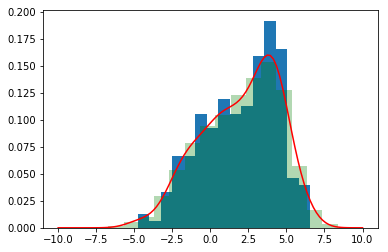

In [46]:
plt.hist(x, 15, normed=True);
plt.plot(xx, kde.evaluate(xx), c='r')
plt.hist(brute_force_draw(kde, N=10000), 15, color='g', normed=True, alpha=0.3)

# Do this in pymc3

In [42]:
def from_hist(param, kde, xlim=(-10,10), N=100):
    width = xlim[1] - xlim[0]
    x = np.linspace(xlim[0], xlim[1], N)
    y = kde.evaluate(x)
    
    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return Interpolated(param, x, y)

In [43]:
model = Model()
with model:
    # Priors are posteriors from previous iteration
    dat = from_hist('dat', kde)

    # draw 10000 posterior samples
    trace = sample(10000)


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
  0%|          | 0/200000 [00:00<?, ?it/s]
Convergence archived at 100
Interrupted at 100 [0%]: Average Loss = 9.7185
100%|██████████| 10500/10500 [00:08<00:00, 1207.10it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122a67ba8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x122ab2e80>]], dtype=object)

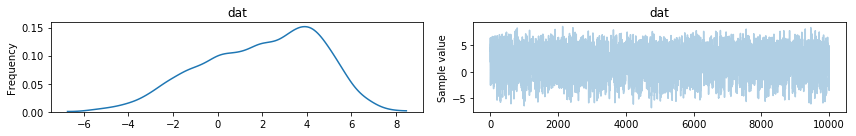

In [44]:
traceplot(trace)

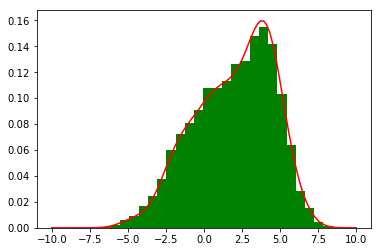

In [45]:
plt.plot(xx, kde.evaluate(xx), c='r')
plt.hist(trace['dat'], 25, normed=True, color='g');